# Hate Speech Detection using Deep Learning (LSTM)

**Course:** CSE485 – Deep Learning  
**Dataset:** Hate Speech Tweets Dataset  


In [ ]:
# OPTIONAL (run once only if dataset is not available locally)
# This cell downloads the dataset from the source and saves it locally

# import pandas as pd
# url = "https://media.geeksforgeeks.org/wp-content/uploads/20250321123144355200/Dataset---Hate-Speech-Detection-using-Deep-Learning.csv"
# df = pd.read_csv(url)
# df.to_csv("../data/hate_speech.csv", index=False)


## Environment Setup
This notebook requires the libraries listed in `requirements.txt`.
Additionally, the following NLTK resources must be downloaded:
- stopwords
- wordnet
- omw-1.4

In [56]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Deep Learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional


# HTML display
import html


## Step 1 Database Visualizations

### Loading data and counting

In [5]:
df = pd.read_csv("../data/hate_speech.csv")
df.head()


,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [30]:
df.shape

(24783, 6)

In [29]:
df['class'].value_counts()


class
1    19190
2     4163
0     1430
Name: count, dtype: int64

### Visualizations

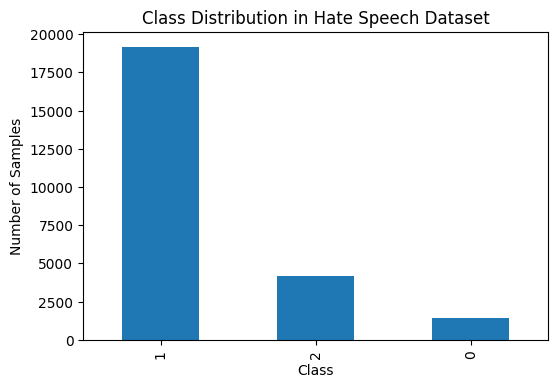

In [7]:
plt.figure(figsize=(6,4))
df['class'].value_counts().plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Hate Speech Dataset")
plt.show()


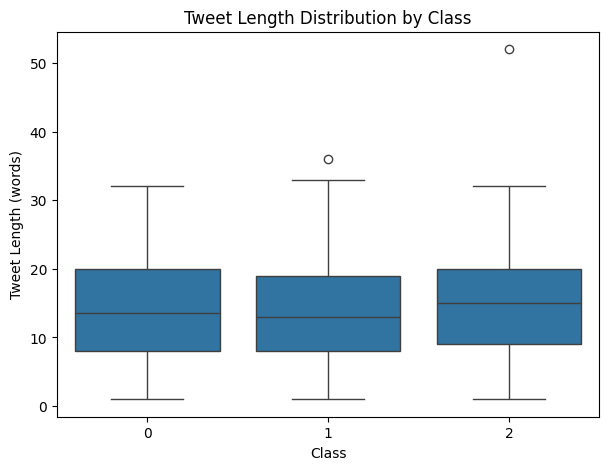

In [13]:
df['tweet_length'] = df['tweet'].apply(lambda x: len(x.split()))

plt.figure(figsize=(7,5))
sns.boxplot(x='class', y='tweet_length', data=df)
plt.xlabel("Class")
plt.ylabel("Tweet Length (words)")
plt.title("Tweet Length Distribution by Class")
plt.show()


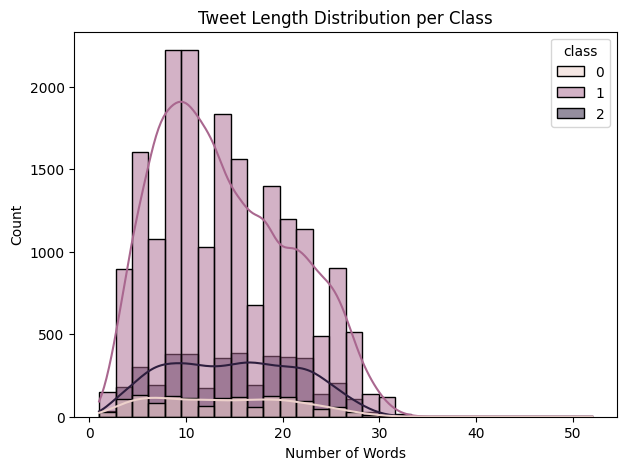

In [12]:
plt.figure(figsize=(7,5))
sns.histplot(data=df, x='tweet_length', hue='class', bins=30, kde=True)
plt.title("Tweet Length Distribution per Class")
plt.xlabel("Number of Words")
plt.show()


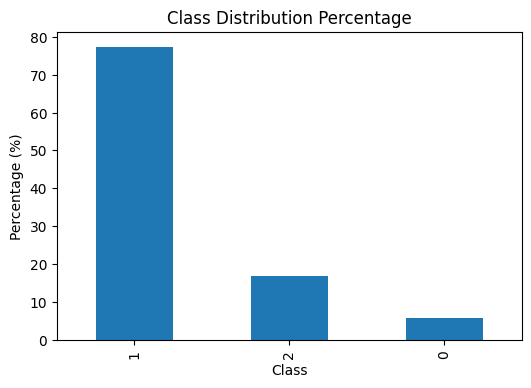

In [9]:
class_percent = df['class'].value_counts(normalize=True) * 100

plt.figure(figsize=(6,4))
class_percent.plot(kind='bar')
plt.ylabel("Percentage (%)")
plt.xlabel("Class")
plt.title("Class Distribution Percentage")
plt.show()


### Class weights to balance the dataset

In [8]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['class']),
    y=df['class']
)

class_weights = dict(zip(np.unique(df['class']), class_weights))
class_weights


{0: 5.776923076923077, 1: 0.43048462741010945, 2: 1.9843862599087196}

## Step 2 Text Preprocessing

### Text Cleaning

In [21]:
def clean_text(text):
    text = html.unescape(text)                       # decode HTML entities (&amp; -> &)
    text = text.lower()
    text = re.sub(r'\brt\b', '', text)               # remove RT
    text = re.sub(r'http\S+|www\S+', '', text)       # remove URLs
    text = re.sub(r'@\w+', '', text)                 # remove mentions
    text = re.sub(r'#', '', text)                    # remove hashtag symbol
    text = re.sub(r'[^a-z\s]', '', text)             # remove punctuation & numbers
    text = re.sub(r'\s+', ' ', text).strip()         # remove extra spaces
    return text


In [31]:

df['clean_tweet'] = df['tweet'].apply(clean_text)


### Stopwords Removal + Lemmatization

In [32]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = text.split()
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
    ]
    return ' '.join(tokens)


In [33]:
df['processed_tweet'] = df['clean_tweet'].apply(preprocess_text)


### Verifying Cleaning is good enough

#### Comparing between tweet, After cleaning, After processing

In [36]:
# Random samples
df[['tweet', 'clean_tweet', 'processed_tweet']].sample(10, random_state=42)


,tweet,clean_tweet,processed_tweet
2281,934 8616\ni got a missed call from yo bitch,i got a missed call from yo bitch,got missed call yo bitch
15914,RT @KINGTUNCHI_: Fucking with a bad bitch you gone need some money lil homie!,fucking with a bad bitch you gone need some money lil homie,fucking bad bitch gone need money lil homie
18943,"RT @eanahS__: @1inkkofrosess lol my credit ain't no where near good , but I know the right man for the job .. that ho nice though!",lol my credit aint no where near good but i know the right man for the job that ho nice though,lol credit aint near good know right man job ho nice though
16407,RT @Maxin_Betha Wipe the cum out of them faggot RT @80sbaby4life Contact lens is wildin can't see shit,wipe the cum out of them faggot contact lens is wildin cant see shit,wipe cum faggot contact lens wildin cant see shit
13326,Niggas cheat on they bitch and don't expect no pay back WHATSOEVER. Yall just as naive as these bitches.,niggas cheat on they bitch and dont expect no pay back whatsoever yall just as naive as these bitches,nigga cheat bitch dont expect pay back whatsoever yall naive bitch
12914,"Mother asked what I wanted for Christmas this year. Replied with for her to not go crazy, and my sister to not be a bitch.",mother asked what i wanted for christmas this year replied with for her to not go crazy and my sister to not be a bitch,mother asked wanted christmas year replied go crazy sister bitch
21457,"That's real dedication. .. &#171;@arigold_88 This bitch got diarrhea and still here, shitting up the bathroom.&#187;",thats real dedication this bitch got diarrhea and still here shitting up the bathroom,thats real dedication bitch got diarrhea still shitting bathroom
12246,"Kiss IMO this conductor, it's 4:30 AM have some courtesy you bitch.",kiss imo this conductor its am have some courtesy you bitch,kiss imo conductor courtesy bitch
13083,My momma keep talking to me like bitch gtf I'm on Twitter.,my momma keep talking to me like bitch gtf im on twitter,momma keep talking like bitch gtf im twitter
19409,RT @karlos_budah: I kno this bitch a thot she wanna meet my momma now,i kno this bitch a thot she wanna meet my momma now,kno bitch thot wanna meet momma


#### Checking most common words to make sure we removed unnecessary data

In [26]:
from collections import Counter

all_words = ' '.join(df['processed_tweet']).split()
Counter(all_words).most_common(30)


[('bitch', 11332),
 ('hoe', 4279),
 ('like', 2819),
 ('pussy', 2227),
 ('im', 2090),
 ('nigga', 1991),
 ('dont', 1781),
 ('as', 1571),
 ('get', 1537),
 ('u', 1463),
 ('fuck', 1448),
 ('got', 1290),
 ('shit', 1281),
 ('aint', 1169),
 ('trash', 1151),
 ('lol', 1070),
 ('know', 855),
 ('one', 751),
 ('love', 738),
 ('girl', 695),
 ('go', 694),
 ('cant', 670),
 ('want', 660),
 ('yall', 660),
 ('fucking', 630),
 ('thats', 625),
 ('yo', 616),
 ('make', 596),
 ('bird', 588),
 ('look', 582)]

#### Length Distribution AFTER Cleaning

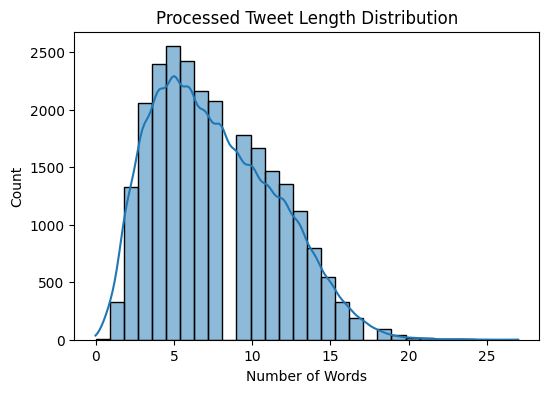

In [38]:
df['processed_length'] = df['processed_tweet'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.histplot(df['processed_length'], bins=30, kde=True)
plt.title("Processed Tweet Length Distribution")
plt.xlabel("Number of Words")
plt.show()


### Tokenization & Padding

In [39]:
MAX_WORDS = 10000   # vocabulary size
MAX_LEN = 20        # max sequence length

tokenizer = Tokenizer(
    num_words=MAX_WORDS,
    oov_token="<OOV>"
)


In [40]:
tokenizer.fit_on_texts(df['processed_tweet'])
sequences = tokenizer.texts_to_sequences(df['processed_tweet'])
print(df['processed_tweet'].iloc[0])
print(sequences[0])


woman shouldnt complain cleaning house man always take trash
[98, 845, 936, 2993, 203, 35, 83, 67, 16]


In [42]:
X = pad_sequences(
    sequences,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)
y = df['class'].values

print(X.shape)

(24783, 20)


## Step 3 Dataset Splitting

### Train 70%, test and val 15%

In [44]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)


### Verifying shapes and distribution

In [47]:
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (17348, 20)
Validation: (3717, 20)
Test: (3718, 20)


In [46]:
def class_distribution(y, name):
    print(f"\n{name} distribution:")
    print(pd.Series(y).value_counts(normalize=True))

class_distribution(y_train, "Train")
class_distribution(y_val, "Validation")
class_distribution(y_test, "Test")



Train distribution:
1    0.774326
2    0.167973
0    0.057701
Name: proportion, dtype: float64

Validation distribution:
1    0.774280
2    0.167877
0    0.057842
Name: proportion, dtype: float64

Test distribution:
1    0.774341
2    0.168101
0    0.057558
Name: proportion, dtype: float64


## Step 4 Model Architecture

### Build Model


In [145]:
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128),
    LSTM(96),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])


### Compile And Summary

In [146]:
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Step 5 Model Training 

In [147]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



In [148]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping]
)


Epoch 1/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6626 - loss: 1.0111 - val_accuracy: 0.7821 - val_loss: 0.6681
Epoch 2/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8223 - loss: 0.5742 - val_accuracy: 0.8052 - val_loss: 0.5686
Epoch 3/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8448 - loss: 0.3970 - val_accuracy: 0.8652 - val_loss: 0.3745
Epoch 4/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8731 - loss: 0.3051 - val_accuracy: 0.8015 - val_loss: 0.5399
Epoch 5/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8944 - loss: 0.2447 - val_accuracy: 0.8606 - val_loss: 0.4307
Epoch 6/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9188 - loss: 0.1857 - val_accuracy: 0.8181 - val_loss: 0.5078
Epoch 7/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9192 - loss: 0.1729 - val_accuracy: 0.8162 - val_loss: 0.5623
Epoch 8/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9289 - loss: 0.1500 - val_accuracy: 0.

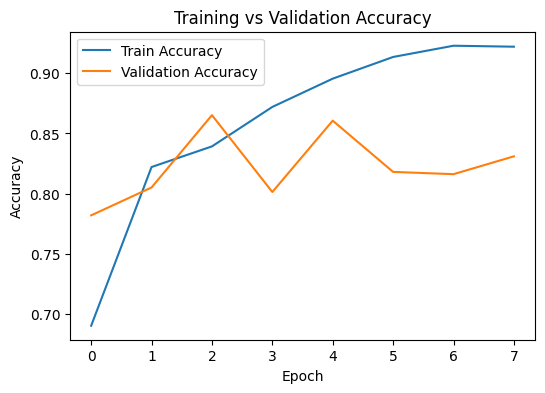

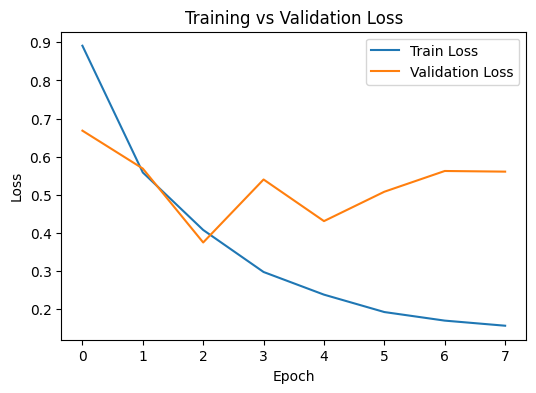

In [149]:
#Accuracy plot

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

#Loss plot
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()
